### Training and testing of the DistilBert model on the train dataset (Reddit book reviews)

In [1]:
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login
import numpy as np
import evaluate


In [45]:
from scipy.special import softmax
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [2]:
train_dataset = load_dataset("csv", data_files="books_train.csv")["train"]
test_dataset = load_dataset("csv", data_files="books_test.csv")["train"]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [4]:
def preprocess_function(examples):
   return tokenizer(examples["body"], truncation=True)
 
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


In [5]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [6]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_f1 = evaluate.load("f1")
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)
   f1 = load_f1.compute(predictions=predictions, references=labels)
   return {"accuracy": accuracy, "f1": f1}

In [8]:
repo_name = "finetuning-distibert-Reddit-books"
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


/home/demomaks/python_environments/anya/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/tmp/ipykernel_34169/1078629372.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=26, training_loss=0.6020357425396259, metrics={'train_runtime': 208.8891, 'train_samples_per_second': 1.915, 'train_steps_per_second': 0.124, 'total_flos': 51536027486496.0, 'train_loss': 0.6020357425396259, 'epoch': 2.0})

In [10]:
trainer.evaluate()

{'eval_loss': 0.5746938586235046,
 'eval_accuracy': {'accuracy': 0.72},
 'eval_f1': {'f1': 0.8372093023255814},
 'eval_runtime': 13.5478,
 'eval_samples_per_second': 7.381,
 'eval_steps_per_second': 0.517,
 'epoch': 2.0}

### Get logits for the test set

In [15]:
predictions = trainer.predict(tokenized_test)
logits = predictions[0]

In [22]:
probabilities = softmax(logits, axis=1)

In [111]:
y_true = np.array(test_dataset["label"])
precision = []
recall = []
threshold = list(np.arange(0.65, 0.75, 0.01))
for t in threshold:
    y_scores = (probabilities[:, 1] > t).astype(int)
    precision.append(precision_score(y_true, y_scores, zero_division=1))
    recall.append(recall_score(y_true, y_scores, zero_division=1))

### Baseline model
Always returns the most frequent class

In [117]:
y_score_baseline = np.ones(y_true.shape)
baseline_precision = precision_score(y_true, y_score_baseline, zero_division=1)
baseline_recall = recall_score(y_true, y_score_baseline, zero_division=1)

### Default
How we usually calculated

In [123]:
y_score_default = predictions.predictions.argmax(axis=-1)
default_precision = precision_score(y_true, y_score_default, zero_division=1)
default_recall = recall_score(y_true, y_score_default, zero_division=1)

In [125]:
y_score_default

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Plot all results

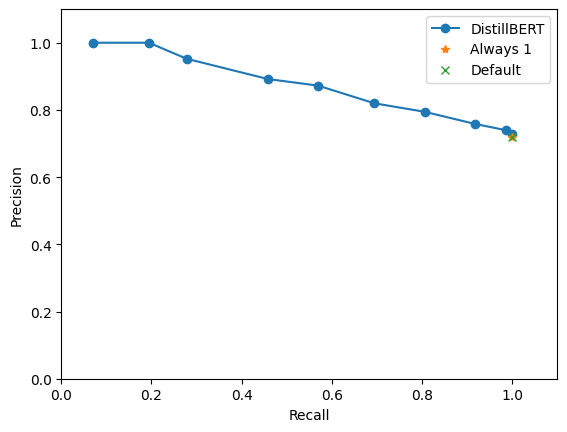

In [124]:
fig, ax = plt.subplots()
ax.plot(recall, precision, '-o', label='DistillBERT')
ax.plot([baseline_recall], [baseline_precision], '*', label='Always 1')
ax.plot([default_recall], [default_precision], 'x', label='Default')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1.1))
ax.legend()

## The accuracy is 0.72, while the F1-score is 0.8372093023255814

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Ground truth labels (binary: 0 or 1)
y_true = test_dataset["label"]
predictions = trainer.predict(tokenized_test)
predicted_labels = predictions.predictions.argmax(axis=-1)
y_scores = predicted_labels 

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

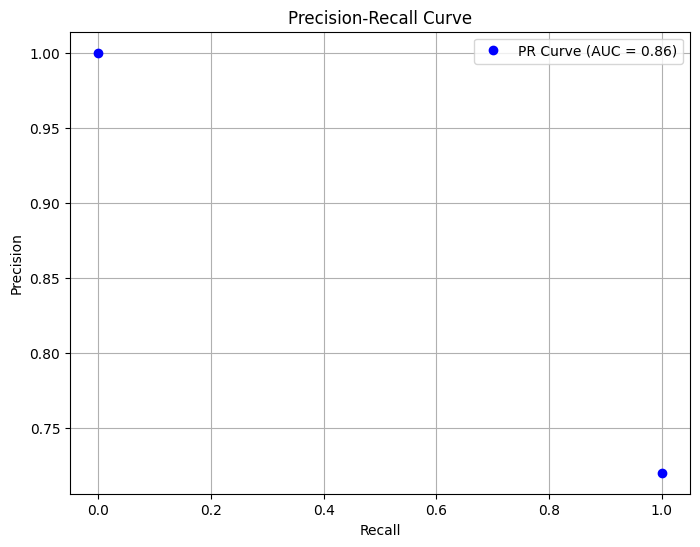

In [ ]:
# Compute AUC for PR curve
pr_auc = auc(recall, precision)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, 'o', label=f"PR Curve (AUC = {pr_auc:.2f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

In [38]:
trainer.log_metrics()

TypeError: log_metrics() missing 2 required positional arguments: 'split' and 'metrics'